Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

2023-11-18 20:28:12.944061: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:28:12.989558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 20:28:12.989624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 20:28:12.991783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 20:28:12.999119: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:28:12.999879: I tensorflow/core/platform/cpu_feature_guard.cc:1

Load Dataset

In [2]:
# Read data from CSV file
df3 = pd.read_csv('data.csv', sep=",", decimal=".")

# Calculate z-scores for the 'price' column and filter out values with z-scores greater than 0.8 for data normalization
from scipy.stats import zscore
z_scores = zscore(df3["price"])
abs_z_scores = np.abs(z_scores)
df3 = df3[(abs_z_scores < 0.8)]

# Drop redundant columns from the DataFrame
df3 = df3.drop(["date", "waterfront", "view", "yr_built", "yr_renovated", "street", "statezip", "country"], axis=1)

# Check for missing values in the DataFrame (There are no missing values)
missing_values = df3.isnull().sum()

# Perform one-hot encoding for the 'city' column to get rid of categorical data
df3 = pd.get_dummies(df3, columns=['city'])
# Convert boolean values to integers (1 for True, 0 for False)
df3 = df3.astype(int)

# Separate features (x3) and target variable (y3)
x1, y1 = df3.drop(["price"], axis=1), df3[["price"]]

Train-Test Split

In [3]:
# Split the data into training and testing sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

Scale Features and Target Variable

In [4]:
scaler = MinMaxScaler()
x1_train_scaled = scaler.fit_transform(x1_train)
x1_test_scaled = scaler.transform(x1_test)
y1_train_scaled = scaler.fit_transform(y1_train.values.reshape(-1, 1)).flatten()
y1_test_scaled = scaler.transform(y1_test.values.reshape(-1, 1)).flatten()


Create and Train Neural Network Model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x1_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')  # Use mean squared error for regression

# Train the model
history = model.fit(x1_train_scaled, y1_train_scaled, epochs=100, validation_split=0.2, verbose=0)


Make Predictions

In [6]:
nn_predictions_scaled = model.predict(x1_test_scaled).flatten()

# Reverse scaling for evaluation metrics
nn_predictions = scaler.inverse_transform(nn_predictions_scaled.reshape(-1, 1)).flatten()


27/27 [==============================] - 0s 1ms/step


Evaluate Model Performance

In [7]:
mape_nn = mean_absolute_percentage_error(y1_test, nn_predictions)
print(f"MAPE for Neural Network: {mape_nn}")

mae_nn = mean_absolute_error(y1_test, nn_predictions)
print(f"MAE for Neural Network: {mae_nn}")


MAPE for Neural Network: 0.18764892062420246
MAE for Neural Network: 79392.42348400298


Scatter Plot

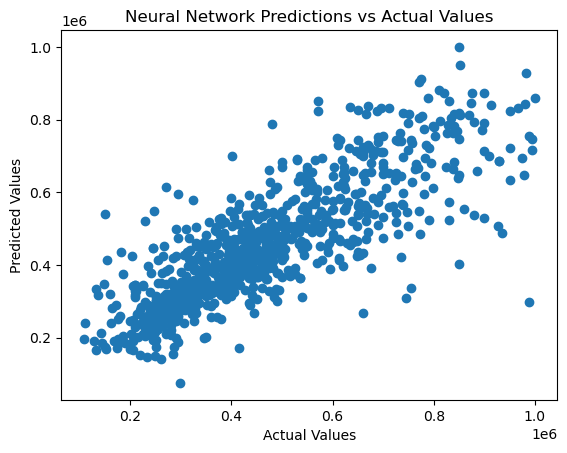

In [8]:
plt.scatter(y1_test, nn_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network Predictions vs Actual Values")
plt.show()
